# Finding the optimal split 



1. Find the best partition for `default ~ balance` to a random subset of 1000 rows of the default data from the ISLR library.


In [5]:
#!pip install python-graphviz

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn import tree
#from graphviz import Source
#import graphviz

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error

In [116]:
df = pd.read_csv('../data/Default.csv')
df = df.sample(n=1000, random_state=1)
df["default"].value_counts()

No     967
Yes     33
Name: default, dtype: int64

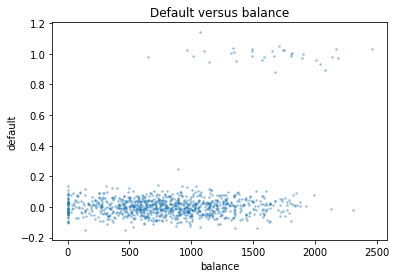

In [117]:
#add jitter to your plot:
N = df.shape[0]
df["default2"] = df["default"] == "Yes"
df["defaultJitter"] = df["default2"] + 0.05*np.random.randn(N)
plt.scatter(df["balance"], df["defaultJitter"],s = 2.5, alpha=0.35)
plt.xlabel('balance')
plt.ylabel('default')
plt.title('Default versus balance')
#plt.legend(['specificity', 'sensitivity'],fontsize=14)
plt.show();

## Find best threshold

In [139]:
df_l = df[df["balance"]<1000]
df_r = df[df["balance"]>=1000]
df_sorted = pd.concat([df_l,df_r])
df_sorted

,Unnamed: 0,default,student,balance,income,default2,defaultJitter
5756,5757,No,Yes,0.000000,17648.35555,False,-0.032338
8516,8517,No,No,0.000000,51122.51562,False,-0.101814
9219,9220,No,Yes,0.000000,18251.72562,False,0.056292
9519,9520,No,No,0.000000,45178.59169,False,-0.065796
2512,2513,No,No,0.000000,30049.10026,False,-0.034992
...,...,...,...,...,...,...,...
2354,2355,Yes,Yes,2134.934488,20330.86487,True,0.981159
3123,3124,Yes,Yes,2169.196187,18195.26690,True,1.029540
6077,6078,Yes,No,2187.224846,42205.12305,True,0.974816
2140,2141,No,Yes,2308.893236,19110.26641,False,-0.017450


In [132]:
df = df.sort_values('balance')
X = df[["balance"]]
y = df.default.map(dict(Yes=1, No=0))

In [138]:
mse_results = []
grid = np.arange(0,2500,1)

for step in grid:
    df_l = df[df["balance"]<step]
    df_r = df[df["balance"]>=step]
    df_sorted = pd.concat([df_l,df_r])
    y_pred = np.empty(y.shape)
    y_pred[:step] = np.mean(df_sorted[df_sorted["balance"]<step])
    y_pred[step:] = np.mean(df_sorted[df_sorted["balance"]>=step])
    mse_results.append(mean_squared_error(df_sorted.default.map(dict(Yes=1, No=0)),y_pred))

ValueError: could not broadcast input array from shape (7) into shape (0)

In [134]:
opt_thres = grid[np.argmin(mse_results)]
opt_thres

1000

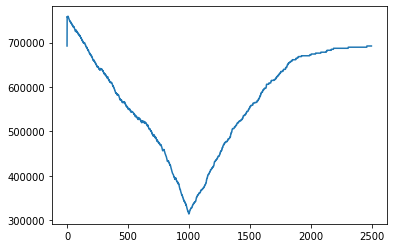

In [135]:
plt.plot(mse_results)

In [110]:
X.shape

(1000, 1)

# Clemens solution

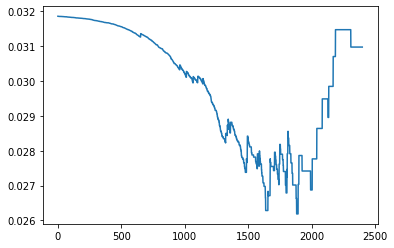

In [118]:
max = 2400
mse_left = np.zeros(max)
mse_right = np.zeros(max)

df_sorted = df.sort_values('balance')
df_sorted['default2'] = df_sorted['default'].apply(lambda x: 1 if x=='Yes' else 0)

for i in range(max):
    df_left = df[df['balance'] < i]
    df_right = df[df['balance'] >= i]
    
    mse_left[i] = (np.mean(df_left['default2'] - np.mean(df_left['default2'])**2)) * (df_left.size/(df_left.size+df_right.size))
    mse_right[i] = (np.mean(df_right['default2'] - np.mean(df_right['default2'])**2)) * (df_right.size/(df_left.size+df_right.size))
    
best = mse_left + mse_right
plt.plot(best)


# Trees

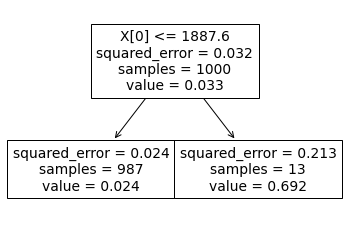

In [123]:
##tree

clf = DecisionTreeRegressor(max_depth=1)

clf = clf.fit(df[["balance","income"]], df["default2"])

plot_tree(clf);

In [137]:
# MSE reduction
MSEParent = 0.032
MSELChild = 0.024
MSERChild = 0.213

MSEreduction = MSEParent -(0.987*MSELChild + 0.013 * MSERChild)
MSEreduction

0.005542999999999999

## Loss function

node impurity = loss function for Tree = Gini index = Gini impurity
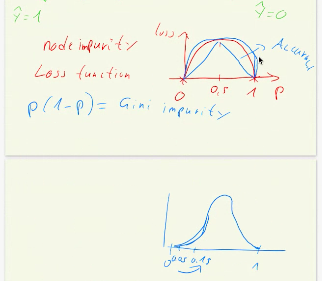

Task: Impurity reduction due to first split
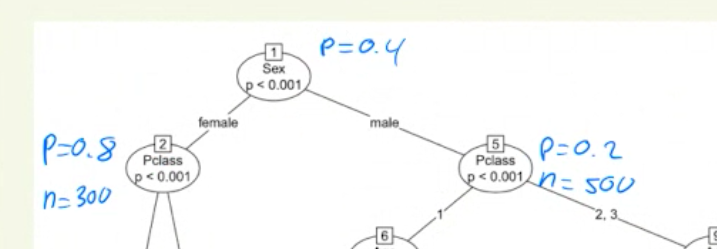
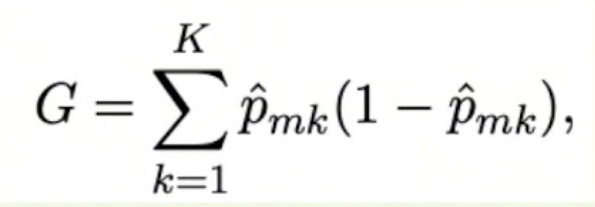

In [156]:
p1 = 0.4
p1_2 = 0.6 #1-0.4
p2 = 0.8
n2 = 300
p3 = 0.2
n3 = 500

giniParent = p1*(1-p1) + p1_2*(1-p1_2)
giniParent = 2*(p1*(1-p1)) #2 because target variable is binary class
giniParent

0.48

In [149]:
gini_n2 = 2*(p2*(1-p2))
gini_n3 = 2*(p3*(1-p3))

In [147]:
gini_reduction = giniParent -(gini_n2*n2/(n2+n3)+gini_n3*n3/(n2+n3))
gini_reduction

0.15999999999999998

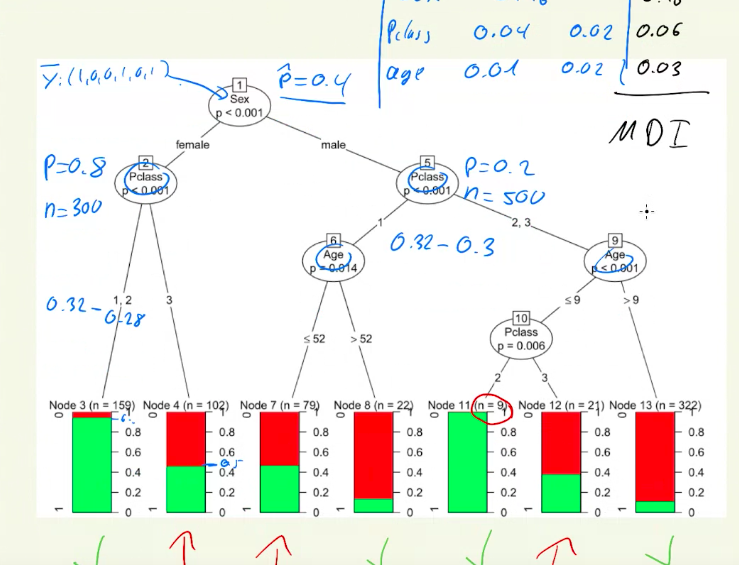

In [162]:
#MDI = Mean decrease impurity

- could use trees for implicit feature selection
- but full of interactions (trees are pretty bad for linear model)
- in a highly iteractive model these features are relevant, but you might throw away useful features (good as rule of thumb) 

# Feature importance

local feature importance and global feature importance<br>
https://blog.datadive.net/interpreting-random-forests/<br>
https://github.com/slundberg/shap<br>

SHAP: the more spread the more global important is the feature
better to interpret, because on same scale (ex. hosue price) not Gini (hard to interpret)